In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from os import listdir
import seaborn as sns
import glob

plt.style.use('./fig.mplstyle')

In [38]:
def running_avg(x, ws):
    '''Computes a running average over x'''
    # ws = int(len(x)/n_windows)  # size of each window
    return [np.sum(x[i*ws:i*ws+ws])/ws for i in range(int(len(x)/ws))]

In [39]:
resdir = '../experiments/results_exp_12_3e5'

In [40]:
parq_list = glob.glob(join(resdir, '*/tr_rewards.parquet'))
config_list = glob.glob(join(resdir, '*/*_config.csv'))

In [41]:
config_list = [
    '../experiments/results_exp_12_3e5/1/1_config.csv', 
    '../experiments/results_exp_12_3e5/2/2_config.csv',  
    '../experiments/results_exp_12_3e5/3/3_config.csv',
    '../experiments/results_exp_12_3e5/4/4_config.csv',
    '../experiments/results_exp_12_3e5/5/5_config.csv',
]

In [42]:
decay_name = {
    "0.99997" : "fast",
    "0.999965" : "medium",
    "0.999975" : "faster",
    "0.99999" : "slow",
    "1.0" : "none"
}

## Training curve

{'epsilon': 1.0, 'epsilon decay': 0.99997, 'alpha': 0.1, 'alpha decay': 0.99999, 'n_episodes': 400000.0, 'rate': 0.0, 'min': 0.0, 'max': 0.0}
{'epsilon': 1.0, 'epsilon decay': 0.999965, 'alpha': 0.1, 'alpha decay': 0.99999, 'n_episodes': 400000.0, 'rate': 0.0, 'min': 0.0, 'max': 0.0}
{'epsilon': 1.0, 'epsilon decay': 0.99997, 'alpha': 0.01, 'alpha decay': 1.0, 'n_episodes': 400000.0, 'rate': 0.0, 'min': 0.0, 'max': 0.0}
{'epsilon': 1.0, 'epsilon decay': 0.999965, 'alpha': 0.01, 'alpha decay': 1.0, 'n_episodes': 400000.0, 'rate': 0.0, 'min': 0.0, 'max': 0.0}
{'epsilon': 1.0, 'epsilon decay': 0.999975, 'alpha': 0.1, 'alpha decay': 0.99999, 'n_episodes': 400000.0, 'rate': 0.0, 'min': 0.0, 'max': 0.0}


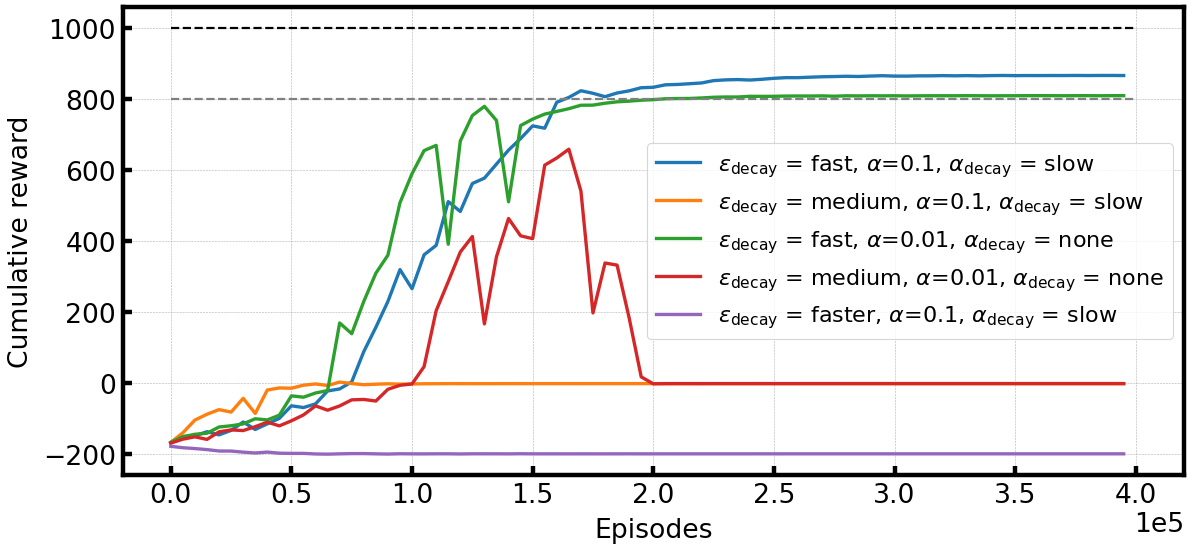

In [43]:
ws = 5000

plt.figure(figsize=(15,7), dpi=80)

for parq, config in zip(parq_list, config_list):
    rewards = pd.read_parquet(parq)["Cumulative reward"].to_numpy()
    mv_avg_rewards = running_avg(rewards, ws)

    params = pd.read_csv(config, names=['param', 'value'])
    params.drop(0, inplace=True)
    params = dict(zip(params["param"].to_list(), params["value"].to_list()))
    print(params)

    x_axis = ws * np.arange(len(mv_avg_rewards))
    label = rf'$\epsilon_{{\text{{decay}}}}$ = {decay_name[str(params["epsilon decay"])]}, ' + \
    rf'$\alpha$={params["alpha"]}, ' + \
    rf'$\alpha_{{\text{{decay}}}}$ = {decay_name[str(params["alpha decay"])]}'
    plt.plot(x_axis, mv_avg_rewards, label=label)


plt.hlines(1000, xmin=0, xmax=4e5, colors='black', ls='--', lw=2)
plt.hlines(800, xmin=0, xmax=4e5, colors='grey', ls='--', lw=2)
plt.grid(True, which="both", lw=0.5, ls='--')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.tight_layout()
plt.savefig('training.png')

## Evaluation curve

In [44]:
path = "../experiments/results_exp_12_3e5/eval_results/2a53a9ba-a62c-4b60-8e9f-39ba8dc47ed7.parquet"

In [45]:
eval_df = pd.read_parquet(path)
eval_df.head()

,Experiment id,Eval id,Eval seed,Cumulative reward,Delay 0,Delay 1,Delay 2,Delay 3,Delay 4,# arrived,# arrived on time
0,3,0,3293720457,644.0,None,-8.0,-4.0,-24.0,-28.0,4,4


In [31]:
parq_dir = glob.glob("../experiments/results_exp_12_3e5/eval_results/*.parquet")

In [32]:
for parq in parq_dir:
    eval_df = pd.read_parquet(parq)
    print(f"Experiment_id: {eval_df['Experiment id'].iloc[0]}, # arrived on times: {eval_df['# arrived on time'].iloc[0]}")

Experiment_id: 2, # arrived on times: 4
Experiment_id: 6, # arrived on times: 0
Experiment_id: 5, # arrived on times: 0
Experiment_id: 4, # arrived on times: 0
Experiment_id: 1, # arrived on times: 1
Experiment_id: 3, # arrived on times: 4


## Evaluation from Q-tables

In [33]:
import os

In [34]:
exp_dir = "../experiments/results_exp_12_3e5/1"

In [35]:
config = pd.read_csv(os.path.join(exp_dir,"1_config.csv"))
config

,Unnamed: 0,0
0,epsilon,1.00000
1,epsilon decay,0.99997
2,alpha,0.10000
3,alpha decay,0.99999
4,n_episodes,400000.00000
5,rate,0.00000
6,min,0.00000
7,max,0.00000


In [21]:
import sys 
import os 
sys.path.append(os.path.abspath('../'))

from flatland_tools.agent import TQLearningAgent

agent_path = "../experiments/results_exp_12_3e5/1/qtables/qtable_400000.pkl"

agent=TQLearningAgent.load(agent_path)

In [47]:
from train import generate_env
from training_utils import eval_once

def eval_batch(
    malf_rate: float,
    malf_min: int,
    malf_max: int,
    malf_seeds: np.ndarray[int],
    exp_id: int,
    first_eval_id: int,
    agent_path: str,
    out_dir: str
):
    env = generate_env(malf_rate, malf_min, malf_max)
    agent=TQLearningAgent.load(agent_path)

    eval_df = []
    eval_df_columns = \
        ['Experiment id', 'Eval id', 'Eval seed', 'Cumulative reward'] + \
        [f'Delay {i}' for i in range(env.rail_env.get_num_agents())] + \
        ['# arrived', '# arrived on time']
    for idx, malf_seed in enumerate(malf_seeds):
        cumulative_reward, delays, n_arrived, \
            n_arrived_on_time, _ = eval_once(
                env, agent, malf_seed, False
            )
        eval_df.append([
            exp_id,
            first_eval_id + idx,
            malf_seed,
            cumulative_reward,
        ] + [
            delays[train_id] if train_id in delays else None for train_id in range(env.rail_env.get_num_agents())
        ] + [
            n_arrived,
            n_arrived_on_time
        ])

    print(n_arrived_on_time)
    print(n_arrived)
    print(delays)

    # pd.DataFrame(eval_df, columns=eval_df_columns)\
    #     .to_parquet(os.path.join(out_dir, f'{exp_id}_{agent_path.split('/')[-1]}.parquet'))

In [49]:
eval_batch(
    malf_rate=0.0,
    malf_min=0,
    malf_max=0,
    malf_seeds=[0],
    exp_id=1,
    first_eval_id=10,
    agent_path="../experiments/results_exp_12_3e5/1/qtables/qtable_400000.pkl",
    out_dir="."
)

0
0
{3: None, 8: None, 2: None, 5: None, 0: None, 9: None, 7: None}
